In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
#path_results = Path('/opt/models/elmo/ner/results (pre queda energia, datalawyer)')
path_results = Path('/media/discoD/models/elmo/jur/results_ibm')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo
/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer-ft_ELMo+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo+CNN+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-brwac
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-brwac+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-brwac+CNN+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-brwac+Embeddings
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-pt
/media/discoD/models/elmo/jur/results_ibm/datalawyer_ELMo-pt+CNN
/media/discoD/models/elmo/jur/results_ibm/datalawyer

In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('"%s"' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

"datalawyer_ELMo-brwac+CNN+Embeddings_glove_6"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_cbow_5B-jur2vec-nilc_0"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_cbow_5B-jur2vec-nilc_1"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_cbow_5B-jur2vec-nilc_2"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_cbow_5B-jur2vec-nilc_3"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_cbow_5B-jur2vec-nilc_4"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_cbow_5B-jur2vec-nilc_5"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_skip_5B-jur2vec-nilc_0"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_skip_5B-jur2vec-nilc_1"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_skip_5B-jur2vec-nilc_2"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_skip_5B-jur2vec-nilc_3"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_skip_5B-jur2vec-nilc_4"
"datalawyer_ELMo-brwac+CNN+Embeddings_wang2vec-lc_jur_skip_5B-jur2vec-nilc_5"
"datalawyer_ELMo-

In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAIN_SPECIFIC = 'Domain_Specific'
EMBEDDING_DOMAIN = 'Embedding_Domain'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, DOMAIN_SPECIFIC, EMBEDDING_DOMAIN, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Domain_Specific',
 'Embedding_Domain',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 3:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[2]}
    elif len(data) == 4:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], DOMAIN_SPECIFIC: False, EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', DOMAIN_SPECIFIC: True, EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[4], DOMAIN_SPECIFIC: True, EXECUTION_NUMBER: data[6]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    if '-pt' in data[REPRESENTATION]:
        data[MODEL] = 'datalawyer-pt'
        data[REPRESENTATION] = data[REPRESENTATION].replace('-pt', '')
    if '-brwac' in data[REPRESENTATION]:
        data[MODEL] = 'datalawyer-brwac'
        data[REPRESENTATION] = data[REPRESENTATION].replace('-brwac', '')
    if '-lc' in data[EMBEDDING]:
        data[EMBEDDING] = data[EMBEDDING].replace('-lc', '')
        data[DOMAIN_SPECIFIC] = True
    data[DOMAIN_SPECIFIC] = 'Sim' if data[DOMAIN_SPECIFIC] else 'Não'
    data[EMBEDDING_TYPE] = 'glove' if data[EMBEDDING] == 'glove' else data[EMBEDDING_TYPE]
    data[EMBEDDING_DOMAIN] = data[EMBEDDING] + '-' + data[DOMAIN_SPECIFIC]
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer-ft', 'ELMo', '0']
['datalawyer-ft', 'ELMo', '1']
['datalawyer-ft', 'ELMo', '10']
['datalawyer-ft', 'ELMo', '11']
['datalawyer-ft', 'ELMo', '2']
['datalawyer-ft', 'ELMo', '3']
['datalawyer-ft', 'ELMo', '4']
['datalawyer-ft', 'ELMo', '5']
['datalawyer-ft', 'ELMo', '6']
['datalawyer-ft', 'ELMo', '7']
['datalawyer-ft', 'ELMo', '8']
['datalawyer-ft', 'ELMo', '9']
['datalawyer-ft', 'ELMo+CNN', '0']
['datalawyer-ft', 'ELMo+CNN', '1']
['datalawyer-ft', 'ELMo+CNN', '10']
['datalawyer-ft', 'ELMo+CNN', '11']
['datalawyer-ft', 'ELMo+CNN', '2']
['datalawyer-ft', 'ELMo+CNN', '3']
['datalawyer-ft', 'ELMo+CNN', '4']
['datalawyer-ft', 'ELMo+CNN', '5']
['datalawyer-ft', 'ELMo+CNN', '6']
['datalawyer-ft', 'ELMo+CNN', '7']
['datalawyer-ft', 'ELMo+CNN', '8']
['datalawyer-ft', 'ELMo+CNN', '9']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'fasttext-lc', 'jur', 'cbow', '5B-jur2vec-nilc', '1']
['datalawyer-f

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) < 1]
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Domain_Specific,Embedding_Domain,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer-ft_ELMo_0,datalawyer-ft,ELMo,No,No,Não,No-Não,0,4,5,00:26:12,1572.0,314.4,0.990201,0.990597,0.897234,0.892617,0.894920,39.935539,0.987270,0.987657,0.872615,0.889590,0.881021,46.633434,0.986592,0.987099,0.867756,0.911076,0.888889,50.797832
1,datalawyer-ft_ELMo_1,datalawyer-ft,ELMo,No,No,Não,No-Não,1,4,5,00:26:27,1587.0,317.4,0.990072,0.990441,0.896653,0.889933,0.893280,39.944456,0.987324,0.987817,0.882568,0.889064,0.885804,46.596758,0.986032,0.986722,0.873679,0.902756,0.887980,50.931561
2,datalawyer-ft_ELMo_10,datalawyer-ft,ELMo,No,No,Não,No-Não,10,4,5,00:26:35,1595.0,319.0,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090
3,datalawyer-ft_ELMo_11,datalawyer-ft,ELMo,No,No,Não,No-Não,11,4,5,00:26:34,1594.0,318.8,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090
4,datalawyer-ft_ELMo_2,datalawyer-ft,ELMo,No,No,Não,No-Não,2,4,5,00:26:37,1597.0,319.4,0.989994,0.990391,0.894743,0.889038,0.891881,39.689800,0.987244,0.987737,0.874546,0.886961,0.880710,45.476525,0.986565,0.987164,0.871257,0.907956,0.889228,49.654239
5,datalawyer-ft_ELMo_3,datalawyer-ft,ELMo,No,No,Não,No-Não,3,4,5,00:26:14,1574.0,314.8,0.989966,0.990365,0.896164,0.891051,0.893600,40.184671,0.987137,0.987563,0.878772,0.888013,0.883368,46.486709,0.986006,0.986513,0.869238,0.902236,0.885430,50.938980
6,datalawyer-ft_ELMo_4,datalawyer-ft,ELMo,No,No,Não,No-Não,4,4,5,00:26:28,1588.0,317.6,0.989957,0.990374,0.895021,0.890716,0.892863,39.775947,0.987550,0.987990,0.878835,0.888538,0.883660,46.096697,0.986448,0.986956,0.870195,0.906396,0.887927,50.491434
7,datalawyer-ft_ELMo_5,datalawyer-ft,ELMo,No,No,Não,No-Não,5,4,5,00:26:24,1584.0,316.8,0.990036,0.990419,0.894885,0.890380,0.892627,39.982715,0.987204,0.987670,0.878378,0.888538,0.883429,47.215280,0.985394,0.986058,0.864204,0.900156,0.881814,52.648934
8,datalawyer-ft_ELMo_6,datalawyer-ft,ELMo,No,No,Não,No-Não,6,4,5,00:26:25,1585.0,317.0,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090
9,datalawyer-ft_ELMo_7,datalawyer-ft,ELMo,No,No,Não,No-Não,7,4,5,00:26:18,1578.0,315.6,0.989971,0.990385,0.896548,0.891834,0.894185,40.799809,0.987070,0.987523,0.884073,0.890116,0.887084,45.507208,0.985954,0.986592,0.867000,0.901716,0.884017,49.279090


In [10]:
# training_data_df.Model.unique()
# training_data_df = training_data_df[(training_data_df[MODEL] == 'datalawyer') | (training_data_df[MODEL] == 'datalawyer-ft')]

In [11]:
training_data_df.to_csv('training_data_5_epochs_mestrado_datalawyer.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:27:23.146204'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'datalawyer-ft': 'ELMo-af Jurídico', 'datalawyer': 'ELMo Jurídico', 'datalawyer-pt': 'ELMo Wikipedia', 'datalawyer-brwac': 'ELMo brWaC'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor', 'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW', 'glove': 'GloVe'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText', 'wang2vec-lc': 'Wang2Vec', 'glove-lc': 'GloVe', 'word2vec-lc': 'Word2Vec', 'fasttext-lc': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    dataframe = dataframe.rename(index={'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'})
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_datalawyer.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [14]:
get_group_csv('Modelo', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Modelo,,,,,,,,
ELMo-af Jurídico,360.0,88.275206,0.373287,87.127713,0.880586,0.882935,0.885093,89.149261
ELMo Jurídico,360.0,88.254976,0.372831,86.932392,0.880363,0.883031,0.885380,89.116517
ELMo Wikipedia,360.0,86.266621,0.825149,83.379995,0.860373,0.863371,0.867688,87.576065
ELMo brWaC,158.0,85.701416,0.710982,84.066218,0.851995,0.856843,0.861024,87.358101


In [15]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,576.0,87.484404,1.061768,84.884937,0.865400,0.878197,0.883780,89.058914
ELMo+CNN+Vetor,578.0,87.329664,1.211849,84.287966,0.862650,0.878635,0.883433,89.149261
ELMo,42.0,86.741727,2.068688,84.066218,0.845387,0.883958,0.884507,88.922842
ELMo+CNN,42.0,86.594214,1.959590,83.379995,0.846562,0.878255,0.883389,88.746803


In [16]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
GloVe,168.0,87.560462,1.220568,84.766839,0.863371,0.882420,0.886410,89.149261
Skip-Gram,493.0,87.539309,0.997414,84.287966,0.865648,0.880264,0.883436,88.996434
CBoW,493.0,87.222162,1.222105,84.311257,0.863158,0.876581,0.882752,89.074778
Sem Vetor,84.0,86.667971,2.004077,83.379995,0.845387,0.881068,0.884104,88.922842


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Wang2Vec,312.0,87.574303,1.003864,84.450262,0.866565,0.880874,0.883850,88.956743
GloVe,168.0,87.560462,1.220568,84.766839,0.863371,0.882420,0.886410,89.149261
Word2Vec,336.0,87.498616,1.077334,84.287966,0.864656,0.878750,0.883780,89.074778
FastText,338.0,87.084875,1.219164,84.311257,0.860934,0.875951,0.881059,88.877525
Sem Vetor,84.0,86.667971,2.004077,83.379995,0.845387,0.881068,0.884104,88.922842


In [18]:
get_group_csv(['Vetor', 'Domínio Específico'], 'Emb_Dom', [EMBEDDING, DOMAIN_SPECIFIC], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  Desvio Padrão     Mínimo  \
Vetor     Domínio Específico                                                  
Wang2Vec  Sim                    144.0  87.792645       0.736505  85.944179   
GloVe     Não                     84.0  87.640908       1.260055  84.766839   
Word2Vec  Sim                    168.0  87.527217       0.931280  85.184257   
GloVe     Sim                     84.0  87.480015       1.181815  85.062241   
Word2Vec  Não                    168.0  87.470014       1.208022  84.287966   
Wang2Vec  Não                    168.0  87.387152       1.155797  84.450262   
FastText  Não                    170.0  87.099301       1.235959  84.517118   
          Sim                    168.0  87.070278       1.205450  84.311257   
Sem Vetor Não                     84.0  86.667971       2.004077  83.379995   

                                   25%       50%       75%     Máximo  
Vetor     Domínio Específico                                           
Wang2Vec  Sim                 0.874206  0.880959  0.883850  88.776028  
GloVe     Não                 0.864259  0.884870  0.886410  89.149261  
Word2Vec  Sim                 0.866346  0.874191  0.883556  88.996434  
GloVe     Sim                 0.863371  0.881696  0.884855  89.137624  
Word2Vec  Não                 0.863233  0.882353  0.884812  89.074778  
Wang2Vec  Não                 0.864644  0.880853  0.884043  88.956743  
FastText  Não                 0.860934  0.877374  0.881860  88.877525  
          Sim                 0.860768  0.875616  0.880586  88.640407  
Sem Vetor Não                 0.845387  0.881068  0.884104  88.922842

In [19]:
get_group_csv(['Modelo', 'Representação', 'Vetor', 'Tipo de Vetor', 'Domínio Específico'], 'Model_Rep_Emb_Emb-Typ_Dom', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, DOMAIN_SPECIFIC], TEST_F1_MEASURE, replacements_map)

Contagem  \
Modelo           Representação  Vetor     Tipo de Vetor Domínio Específico             
ELMo-af Jurídico ELMo+Vetor     Word2Vec  Skip-Gram     Sim                     12.0   
                                GloVe     GloVe         Sim                     12.0   
                                                        Não                     12.0   
                 ELMo+CNN+Vetor GloVe     GloVe         Não                     12.0   
ELMo Jurídico    ELMo+Vetor     Wang2Vec  CBoW          Sim                     12.0   
                 ELMo+CNN+Vetor GloVe     GloVe         Não                     12.0   
ELMo-af Jurídico ELMo+CNN+Vetor Wang2Vec  Skip-Gram     Não                     12.0   
ELMo Jurídico    ELMo+Vetor     Word2Vec  CBoW          Sim                     12.0   
                                          Skip-Gram     Não                     12.0   
ELMo-af Jurídico ELMo+CNN+Vetor Word2Vec  CBoW          Não                     12.0   
                 ELMo           Sem Vetor Sem Vetor     Não                     12.0   
ELMo Jurídico    ELMo+Vetor     GloVe     GloVe         Não                     12.0   
ELMo-af Jurídico ELMo+CNN+Vetor GloVe     GloVe         Sim                     12.0   
                 ELMo+Vetor     Word2Vec  CBoW          Não                     12.0   
ELMo Jurídico    ELMo+Vetor     Word2Vec  Skip-Gram     Sim                     12.0   
                 ELMo           Sem Vetor Sem Vetor     Não                     12.0   
                 ELMo+Vetor     Wang2Vec  Skip-Gram     Não                     12.0   
ELMo-af Jurídico ELMo+Vetor     Wang2Vec  CBoW          Não                     12.0   
ELMo Jurídico    ELMo+CNN+Vetor Word2Vec  Skip-Gram     Não                     12.0   
ELMo-af Jurídico ELMo+Vetor     Wang2Vec  CBoW          Sim                     12.0   
ELMo Jurídico    ELMo+CNN+Vetor Wang2Vec  Skip-Gram     Não                     12.0   
                                GloVe     GloVe         Sim                     12.0   
                                Word2Vec  CBoW          Não                     12.0   
                 ELMo+Vetor     Word2Vec  CBoW          Não                     12.0   
ELMo-af Jurídico ELMo+CNN+Vetor Wang2Vec  CBoW          Sim                     12.0   
                 ELMo+Vetor     Word2Vec  Skip-Gram     Não                     12.0   
                 ELMo+CNN+Vetor Word2Vec  Skip-Gram     Não                     12.0   
ELMo Jurídico    ELMo+CNN+Vetor FastText  Skip-Gram     Sim                     12.0   
                                Wang2Vec  CBoW          Sim                     12.0   
                                FastText  Skip-Gram     Não                     12.0   
...                                                                              ...   
ELMo Wikipedia   ELMo+CNN+Vetor Wang2Vec  CBoW          Não                     12.0   
                                Word2Vec  CBoW          Sim                     12.0   
ELMo brWaC       ELMo+Vetor     Wang2Vec  Skip-Gram     Não                      6.0   
                 ELMo+CNN+Vetor FastText  Skip-Gram     Sim                      6.0   
ELMo Wikipedia   ELMo+CNN+Vetor Word2Vec  CBoW          Não                     12.0   
                 ELMo+Vetor     FastText  CBoW          Não                     12.0   
ELMo brWaC       ELMo+CNN+Vetor GloVe     GloVe         Sim                      6.0   
                                FastText  Skip-Gram     Não                      7.0   
                 ELMo+Vetor     GloVe     GloVe         Sim                      6.0   
                                Word2Vec  Skip-Gram     Não                      6.0   
                                FastText  Skip-Gram     Não                      6.0   
                 ELMo+CNN+Vetor Wang2Vec  Skip-Gram     Não                      6.0   
                 ELMo+Vetor     GloVe     GloVe         Não                      6.0   
                            

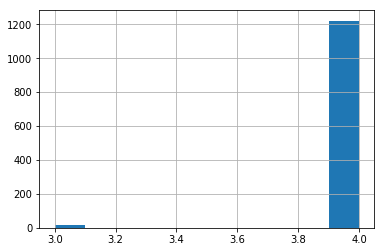

In [20]:
training_data_df[BEST_EPOCH].hist()

In [21]:
training_data_df[TOTAL_DURATION].describe()

count    1238.000000
mean     1643.146204
std       329.020813
min       810.000000
25%      1598.250000
50%      1767.000000
75%      1783.000000
max      2145.000000
Name: Total_Duration(s), dtype: float64

In [22]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
11,90.0,0.876015,0.011028,0.840020,0.869438,0.880681,0.883975,0.890748
9,90.0,0.875995,0.010919,0.839186,0.866929,0.880956,0.884194,0.889964
8,90.0,0.875983,0.010708,0.837720,0.868756,0.880456,0.883815,0.888832
10,90.0,0.875972,0.011089,0.833800,0.869269,0.880995,0.883851,0.888832
7,90.0,0.875925,0.011390,0.841756,0.866666,0.880829,0.884662,0.891376
6,92.0,0.875573,0.010930,0.845387,0.865857,0.880499,0.883492,0.888889
2,116.0,0.871990,0.013249,0.840662,0.860902,0.876638,0.883438,0.891493
5,116.0,0.871866,0.013275,0.838972,0.861019,0.874936,0.883856,0.891165
0,116.0,0.871782,0.012927,0.839858,0.861057,0.874204,0.883453,0.888889


In [23]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,1238.0,0.873568,0.012323,0.00035,0.87288,0.874255


In [24]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,84,0.866680,0.020041,0.002187,0.862394,0.870965
fasttext,338,0.870849,0.012192,0.000663,0.869549,0.872149
glove,168,0.875605,0.012206,0.000942,0.873759,0.877450
wang2vec,312,0.875743,0.010039,0.000568,0.874629,0.876857
word2vec,336,0.874986,0.010773,0.000588,0.873834,0.876138


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING)

Overall model F( 4, 1233) =  16.115, p =  0.00000000000071780978
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     16.12
Date:                Tue, 01 Oct 2019   Prob (F-statistic):           7.18e-13
Time:                        11:33:42   Log-Likelihood:                 3718.0
No. Observations:                1238   AIC:                            -7426.
Df Residuals:                    1233   BIC:                            -7400.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [27]:
print_anova(REPRESENTATION)

Overall model F( 3, 1234) =  11.274, p =  0.00000026756239498949
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     11.27
Date:                Tue, 01 Oct 2019   Prob (F-statistic):           2.68e-07
Time:                        11:33:42   Log-Likelihood:                 3703.1
No. Observations:                1238   AIC:                            -7398.
Df Residuals:                    1234   BIC:                            -7378.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [28]:
print_anova(EMBEDDING_TYPE)

Overall model F( 3, 1234) =  16.437, p =  0.00000000017767713914
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     16.44
Date:                Tue, 01 Oct 2019   Prob (F-statistic):           1.78e-10
Time:                        11:33:42   Log-Likelihood:                 3710.7
No. Observations:                1238   AIC:                            -7413.
Df Residuals:                    1234   BIC:                            -7393.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [29]:
print_anova(EMBEDDING_DOMAIN)

Overall model F( 8, 1229) =  9.326, p =  0.00000000000148423985
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.326
Date:                Tue, 01 Oct 2019   Prob (F-statistic):           1.48e-12
Time:                        11:33:42   Log-Likelihood:                 3722.9
No. Observations:                1238   AIC:                            -7428.
Df Residuals:                    1229   BIC:                            -7382.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------